## Classification Algorithms Applied to Finance - Credit Scoring

In [1]:
#pip install cufflinks

In [2]:
#pip install plotly

In [3]:
import plotly.express as px
import cufflinks as cf
cf.go_offline(True)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [6]:
import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *

In [7]:
data = pd.read_csv("application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("credit_record.csv", encoding = 'utf-8') 

In [8]:
display(data.head())
print('\n')
display(record.head())

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

In [9]:
sns.set_style('white') 

It is worthwile to store the 'age' of the credit history. We shall accomplish this by grouping the months balance by ID and taking the minimum value found.

In [10]:
# find all users' account open month.

#We wish to store this information in a new dataset begin_month.
begin_month = record[['ID','MONTHS_BALANCE']].groupby('ID').agg(min).reset_index()

#display(begin_month.head())
#print("\n")
#display(begin_month.info())

#begin_month = pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
#begin_month.head()

There was a problem with duplicate IDs, which brings noise to data, was detected and solved.

In [11]:
drop_index = data[data.duplicated(subset=['ID'], keep=False)].index
clean_data = data.drop(drop_index)
print(clean_data.shape)
new_data = clean_data.merge(begin_month, on='ID', how='left')
#begin_month = begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
#new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

(438463, 18)


In [12]:
new_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  MONTHS_BALANCE  
0              2.0           -15.0  
1              2.0           -14.0  
2              2.0           -29.0  
3              1.0            -4.0  
4              1.0           -26.0

## Target variable

We shall denote a positive case of default when the value of the status variable is greater or equal to two (Overdue is of 30 days or more).

For this, let us create a new variable / column in the record dataset to store this fact

In [13]:
record['dep_value'] = None
for i in (2, 3, 4, 5):
    record['dep_value'][record['STATUS'] == '{}'.format(i)] = 'x' 
    
'''record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' '''

"record['dep_value'][record['STATUS'] =='2']='Yes' \nrecord['dep_value'][record['STATUS'] =='3']='Yes' \nrecord['dep_value'][record['STATUS'] =='4']='Yes' \nrecord['dep_value'][record['STATUS'] =='5']='Yes' "

In [14]:
#cpunt=record.groupby('ID').count()

It worth precising that a well-behave credit card holder is going to be that person who does NOT record any overdue over 30 along the their whole credit history. Thus we continue by grouping the records by ID and count on the dep_value variable. 

The IDs for which this value is greater that zero incurred at least one time in overdue of 30 days or more.

We save this information in a new dataset cpunt

In [15]:
cpunt = record.groupby('ID').dep_value.count().to_frame(name = 'dep_value').astype('int')

We merge the dataset new_data by inner (intersection) on the ID variable with cpunt in order to work only with ID found in both datasets.

In [16]:
new_data=pd.merge(new_data,cpunt,how='inner',on='ID') 

We finally obtain our target value through the handy np method np.where. Where we get a value diferent from zero on dep_value, our target value will by one and zero otherwise.

In [17]:
#cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'  
#cpunt['dep_value'][cpunt['dep_value'] == 0]='No'  # perfect behaviour 

#cpunt = cpunt[['dep_value']] # use df.drop

new_data['target'] = np.where(new_data['dep_value'] == 0, 0, 1)


#new_data['target'] = new_data['dep_value'] # np.where
#new_data.loc[new_data['target']=='Yes','target']=1
#new_data.loc[new_data['target']=='No','target']=0

In [18]:
new_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  ...  DAYS_EMPLOYED  FLAG_MOBIL  \
0        Civil marriage   Rented apartment  ...          -4542           1   
1        Civil marriage   Rented apartment  ...          -4542           1   
2               Married  House / apartment  ...          -1134           1   
3  Single / not married  House / apartment  ...          -3051           1   
4  Single / not married  House / apartment  ...          -3051           1   

   FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  OCCUPATION_TYPE CNT_FAM_MEMBERS  \
0                1           0           0              NaN             2.0   
1                1           0           0              NaN             2.0   
2                0           0           0   Security staff             2.0   
3                0           1           1      Sales staff             1.0   
4                0           1           1      Sales staff             1.0   

   MONTHS_BALANCE  dep_value  target  
0           -15.0          0       0  
1           -14.0          0       0  
2           -29.0          0       0  
3            -4.0          0       0  
4           -26.0          0       0  

[5 rows x 21 columns]

In [19]:
new_data.sample(10)

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
24971  5100203           F            N               N             0   
23672  5096043           F            N               N             0   
10466  5045545           M            Y               N             2   
11175  5046494           F            N               Y             0   
20206  5089066           M            N               N             3   
17628  5068097           F            Y               Y             1   
15247  5061928           M            Y               Y             0   
16896  5067191           M            Y               Y             0   
2367   5021793           F            N               Y             0   
6573   5029582           F            N               Y             0   

       AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
24971           90000.0             Pensioner  Secondary / secondary special   
23672          112500.0               Working  Secondary / secondary special   
10466          225000.0         State servant               Higher education   
11175          180000.0             Pensioner  Secondary / secondary special   
20206          180000.0               Working  Secondary / secondary special   
17628          234000.0  Commercial associate  Secondary / secondary special   
15247          202500.0             Pensioner  Secondary / secondary special   
16896          180000.0               Working                Lower secondary   
2367           225000.0  Commercial associate  Secondary / secondary special   
6573           180000.0               Working               Higher education   

         NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  ...  DAYS_EMPLOYED  \
24971  Single / not married  House / apartment  ...         365243   
23672               Married       With parents  ...           -584   
10466               Married       With parents  ...          -1539   
11175               Married  House / apartment  ...         365243   
20206               Married  House / apartment  ...          -3535   
17628               Married  House / apartment  ...          -1481   
15247               Married  House / apartment  ...         365243   
16896  Single / not married  House / apartment  ...          -2495   
2367                Married  House / apartment  ...           -187   
6573                Married  House / apartment  ...          -1845   

       FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
24971           1                0           0           0   
23672           1                1           0           0   
10466           1                0           0           0   
11175           1                0           0           0   
20206           1                0           0           0   
17628           1                0           0           0   
15247           1                0           0           0   
16896           1                0           0           0   
2367            1                0           0           0   
6573            1                1           1           0   

             OCCUPATION_TYPE CNT_FAM_MEMBERS  MONTHS_BALANCE  dep_value  \
24971                    NaN             1.0           -29.0          0   
23672                    NaN             2.0           -51.0          0   
10466  High skill tech staff             4.0           -32.0          0   
11175                    NaN             2.0           -20.0          0   
20206               Laborers             5.0           -52.0          0   
17628            Sales staff             3.0            -3.0          0   
15247                    NaN             2.0           -15.0          0   
16896               Laborers             1.0           -34.0          0   
2367              Core staff             2.0           -27.0          0   
6573              Core staff             2.0           -10.0          0   

       target  
24971       0  
23672       0  

## Balance of the database

In [20]:
print(new_data.target.value_counts())
print('-----------------------')
print(new_data.target.value_counts(normalize = True))

0    35841
1      616
Name: target, dtype: int64
-----------------------
0    0.983103
1    0.016897
Name: target, dtype: float64


We observe that we have less than 2% of positive cases, which results in a highly inbalanced dataset. Hence, we shall resolve this issue in the following with the help of the SMOTE.

In [21]:
#print(cpunt['dep_value'].value_counts())
#cpunt['dep_value'].value_counts(normalize=True)

In [22]:
new_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  ...  DAYS_EMPLOYED  FLAG_MOBIL  \
0        Civil marriage   Rented apartment  ...          -4542           1   
1        Civil marriage   Rented apartment  ...          -4542           1   
2               Married  House / apartment  ...          -1134           1   
3  Single / not married  House / apartment  ...          -3051           1   
4  Single / not married  House / apartment  ...          -3051           1   

   FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  OCCUPATION_TYPE CNT_FAM_MEMBERS  \
0                1           0           0              NaN             2.0   
1                1           0           0              NaN             2.0   
2                0           0           0   Security staff             2.0   
3                0           1           1      Sales staff             1.0   
4                0           1           1      Sales staff             1.0   

   MONTHS_BALANCE  dep_value  target  
0           -15.0          0       0  
1           -14.0          0       0  
2           -29.0          0       0  
3            -4.0          0       0  
4           -26.0          0       0  

[5 rows x 21 columns]

## Feature Engineering and descriptive analysis 

In [23]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [24]:
new_data.head()

ID Gender Car Reality  ChldNo       inc                 inctp  \
0  5008804      M   Y       Y       0  427500.0               Working   
1  5008805      M   Y       Y       0  427500.0               Working   
2  5008806      M   Y       Y       0  112500.0               Working   
3  5008808      F   N       Y       0  270000.0  Commercial associate   
4  5008809      F   N       Y       0  270000.0  Commercial associate   

                           edutp                 famtp              houtp  \
0               Higher education        Civil marriage   Rented apartment   
1               Higher education        Civil marriage   Rented apartment   
2  Secondary / secondary special               Married  House / apartment   
3  Secondary / secondary special  Single / not married  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   ...  DAYS_EMPLOYED  FLAG_MOBIL  wkphone  phone  email           occyp  \
0  ...          -4542           1        1      0      0             NaN   
1  ...          -4542           1        1      0      0             NaN   
2  ...          -1134           1        0      0      0  Security staff   
3  ...          -3051           1        0      1      1     Sales staff   
4  ...          -3051           1        0      1      1     Sales staff   

  famsize  MONTHS_BALANCE  dep_value  target  
0     2.0           -15.0          0       0  
1     2.0           -14.0          0       0  
2     2.0           -29.0          0       0  
3     1.0            -4.0          0       0  
4     1.0           -26.0          0       0  

[5 rows x 21 columns]

In [25]:
new_data['Gender'].value_counts().index[0]

'F'

In [26]:
new_data.dropna()
#new_data = new_data.mask(new_data == 'NULL').dropna()

ID Gender Car Reality  ChldNo       inc                 inctp  \
2      5008806      M   Y       Y       0  112500.0               Working   
3      5008808      F   N       Y       0  270000.0  Commercial associate   
4      5008809      F   N       Y       0  270000.0  Commercial associate   
5      5008810      F   N       Y       0  270000.0  Commercial associate   
6      5008811      F   N       Y       0  270000.0  Commercial associate   
...        ...    ...  ..     ...     ...       ...                   ...   
36452  5149828      M   Y       Y       0  315000.0               Working   
36453  5149834      F   N       Y       0  157500.0  Commercial associate   
36454  5149838      F   N       Y       0  157500.0             Pensioner   
36455  5150049      F   N       Y       0  283500.0               Working   
36456  5150337      M   N       Y       0  112500.0               Working   

                               edutp                 famtp              houtp  \
2      Secondary / secondary special               Married  House / apartment   
3      Secondary / secondary special  Single / not married  House / apartment   
4      Secondary / secondary special  Single / not married  House / apartment   
5      Secondary / secondary special  Single / not married  House / apartment   
6      Secondary / secondary special  Single / not married  House / apartment   
...                              ...                   ...                ...   
36452  Secondary / secondary special               Married  House / apartment   
36453               Higher education               Married  House / apartment   
36454               Higher education               Married  House / apartment   
36455  Secondary / secondary special               Married  House / apartment   
36456  Secondary / secondary special  Single / not married   Rented apartment   

       ...  DAYS_EMPLOYED  FLAG_MOBIL  wkphone  phone  email           occyp  \
2      ...          -1134           1        0      0      0  Security staff   
3      ...          -3051           1        0      1      1     Sales staff   
4      ...          -3051           1        0      1      1     Sales staff   
5      ...          -3051           1        0      1      1     Sales staff   
6      ...          -3051           1        0      1      1     Sales staff   
...    ...            ...         ...      ...    ...    ...             ...   
36452  ...          -2420           1        0      0      0        Managers   
36453  ...          -1325           1        0      1      1  Medicine staff   
36454  ...          -1325           1        0      1      1  Medicine staff   
36455  ...           -655           1        0      0      0     Sales staff   
36456  ...          -1193           1        0      0      0        Laborers   

      famsize  MONTHS_BALANCE  dep_value  target  
2         2.0           -29.0          0       0  
3         1.0            -4.0          0       0  
4         1.0           -26.0          0       0  
5         1.0           -26.0          0       0  
6         1.0           -38.0          0       0  
...       ...             ...        ...     ...  
36452     2.0           -11.0          4       1  
36453     2.0           -23.0         11       1  
36454     2.0           -32.0         11       1  
36455     2.0            -9.0          1       1  
36456     1.0           -13.0          1       1  

[25134 rows x 21 columns]

In [27]:
new_data['inc'] = new_data['inc'].apply(lambda x: x/1000)
#normalized income data
#new_data.drop(['inc'], axis=1, inplace=True)
#new_data['inc']=new_data['inc'].astype(object)
#new_data['inc'] = new_data['inc'] / 10000

In [28]:
new_data['Age'] = new_data['DAYS_BIRTH'].apply(lambda x: round(abs(x/365)))
#converted 'days of birth' to the rounded "age"
#mydata.drop(['DAYS_BIRTH'], axis=1, inplace=True)
#new_data['Age'] =- (new_data['DAYS_BIRTH'])//365

In [29]:
new_data.sample(5).T

35456                          25400  \
ID                        5149423                        5105037   
Gender                          F                              F   
Car                             N                              N   
Reality                         Y                              N   
ChldNo                          0                              1   
inc                         202.5                          121.5   
inctp                     Working                        Working   
edutp            Higher education  Secondary / secondary special   
famtp                     Married                        Married   
houtp           House / apartment              House / apartment   
DAYS_BIRTH                 -21664                         -14968   
DAYS_EMPLOYED               -7077                           -118   
FLAG_MOBIL                      1                              1   
wkphone                         0                              0   
phone                           1                              0   
email                           0                              0   
occyp                  Core staff                       Laborers   
famsize                         2                              3   
MONTHS_BALANCE                -38                            -48   
dep_value                       0                              0   
target                          0                              0   
Age                            59                             41   

                                        31055                          23556  \
ID                                    5126476                        5095884   
Gender                                      F                              F   
Car                                         N                              N   
Reality                                     N                              N   
ChldNo                                      0                              1   
inc                                      76.5                          157.5   
inctp                           State servant                        Working   
edutp           Secondary / secondary special  Secondary / secondary special   
famtp                          Civil marriage                          Widow   
houtp                       House / apartment              House / apartment   
DAYS_BIRTH                             -17308                         -18571   
DAYS_EMPLOYED                           -6224                          -4602   
FLAG_MOBIL                                  1                              1   
wkphone                                     1                              1   
phone                                       1                              0   
email                                       0                              0   
occyp                          Medicine staff                            NaN   
famsize                                     2                              2   
MONTHS_BALANCE                            -53                            -17   
dep_value                                   0                              0   
target                                      0                              0   
Age                                        47                             51   

                                        420    
ID                                    5009318  
Gender                                      F  
Car                                         Y  
Reality                                     N  
ChldNo                                      0  
inc                                       135  
inctp                               Pensioner  
edutp           Secondary / secondary special  
famtp                                 Married  
houtp                       House / apartment  
DAYS_BIRTH                             -20140  
DAYS_EMPLOYED                          365243 

In [30]:
new_data.describe() #Descriptive statistics

ID        ChldNo           inc    DAYS_BIRTH  DAYS_EMPLOYED  \
count  3.645700e+04  36457.000000  36457.000000  36457.000000   36457.000000   
mean   5.078227e+06      0.430315    186.685737 -15975.173382   59262.935568   
std    4.187524e+04      0.742367    101.789226   4200.549944  137651.334859   
min    5.008804e+06      0.000000     27.000000 -25152.000000  -15713.000000   
25%    5.042028e+06      0.000000    121.500000 -19438.000000   -3153.000000   
50%    5.074614e+06      0.000000    157.500000 -15563.000000   -1552.000000   
75%    5.115396e+06      1.000000    225.000000 -12462.000000    -408.000000   
max    5.150487e+06     19.000000   1575.000000  -7489.000000  365243.000000   

       FLAG_MOBIL       wkphone         phone         email       famsize  \
count     36457.0  36457.000000  36457.000000  36457.000000  36457.000000   
mean          1.0      0.225526      0.294813      0.089722      2.198453   
std           0.0      0.417934      0.455965      0.285787      0.911686   
min           1.0      0.000000      0.000000      0.000000      1.000000   
25%           1.0      0.000000      0.000000      0.000000      2.000000   
50%           1.0      0.000000      0.000000      0.000000      2.000000   
75%           1.0      0.000000      1.000000      0.000000      3.000000   
max           1.0      1.000000      1.000000      1.000000     20.000000   

       MONTHS_BALANCE     dep_value        target           Age  
count    36457.000000  36457.000000  36457.000000  36457.000000  
mean       -26.164193      0.077571      0.016897     43.777382  
std         16.501854      1.061999      0.128886     11.519211  
min        -60.000000      0.000000      0.000000     21.000000  
25%        -39.000000      0.000000      0.000000     34.000000  
50%        -24.000000      0.000000      0.000000     43.000000  
75%        -12.000000      0.000000      0.000000     53.000000  
max          0.000000     48.000000      1.000000     69.000000

<AxesSubplot:>

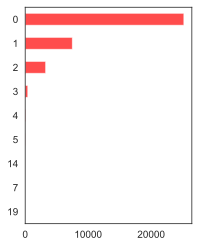

In [31]:
new_data['ChldNo'].value_counts().sort_values().plot(kind='barh', figsize=(3,4), alpha=0.7, color ='r')
#ylabel = "Number of children"

<AxesSubplot:ylabel='ChldNo'>

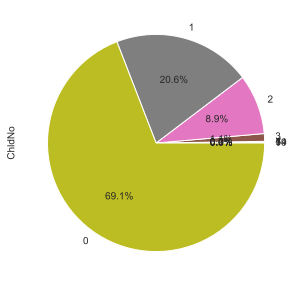

In [32]:
new_data['ChldNo'].value_counts().sort_values().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%')#ylabel = "Number of children"

<AxesSubplot:title={'center':'Annual income'}, ylabel='Frequency'>

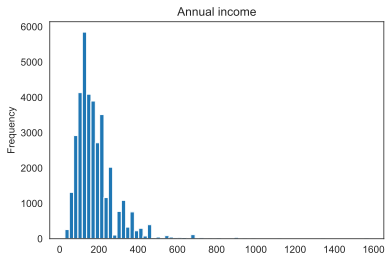

In [33]:
new_data['inc'].plot(kind = 'hist', bins = 70, title = "Annual income")  #we can erase this line on the feature engineering part

<AxesSubplot:title={'center':'Age'}, ylabel='Frequency'>

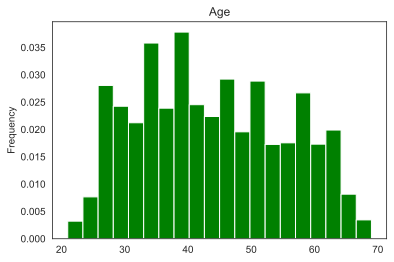

In [34]:
new_data['Age'].plot(kind='hist',bins=20,density=True, title = "Age", color = 'g') #we can erase this line on the feature engineering part

<AxesSubplot:ylabel='famsize'>

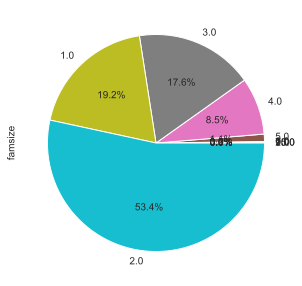

In [35]:
new_data['famsize'].value_counts().sort_values().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%') # ylabel = "Famliy size"

<AxesSubplot:>

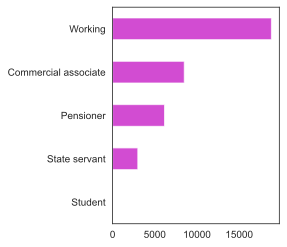

In [36]:
new_data['inctp'].value_counts().sort_values().plot(kind='barh', figsize=(3,4), alpha=0.7, color ='m') #ylabel = "Income Type"

<AxesSubplot:>

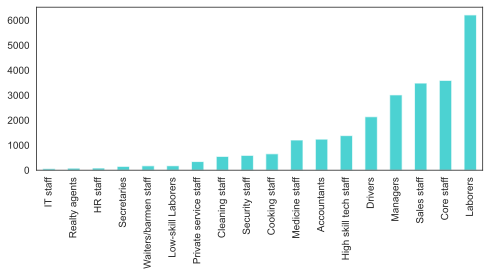

In [37]:
new_data['occyp'].value_counts().sort_values().plot(kind='bar', figsize=(8,3), alpha=0.7, color ='c')#ylabel = "Ocupation Type"

<AxesSubplot:title={'center':'Occupation type'}, ylabel='occyp'>

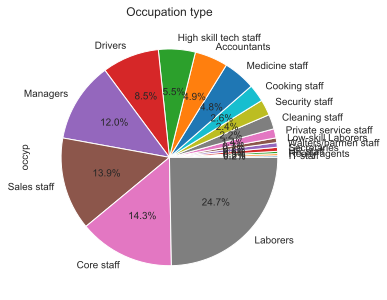

In [38]:
new_data['occyp'].value_counts().sort_values().plot(kind='pie', figsize=(5,5), title = "Occupation type",autopct='%1.1f%%')#, ylabel = None 

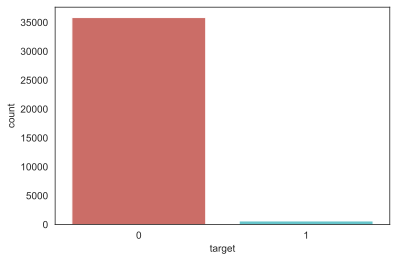

In [39]:
chart=sns.countplot(x='target', data = new_data, palette = 'hls') #unbalanced data

<AxesSubplot:>

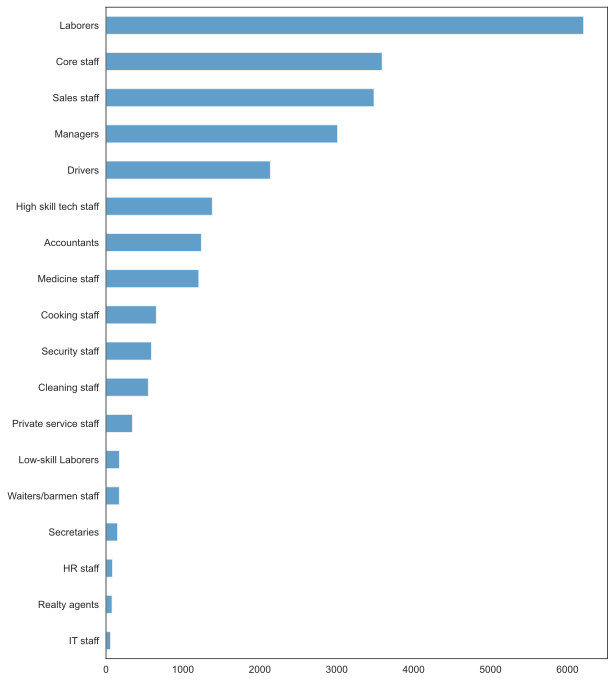

In [40]:
new_data['occyp'].value_counts().sort_values().plot(kind='barh', figsize=(9,12), alpha=0.7) #returns object containing sorted counts of unique values

Text(0, 0.5, 'Number of Defaulters')

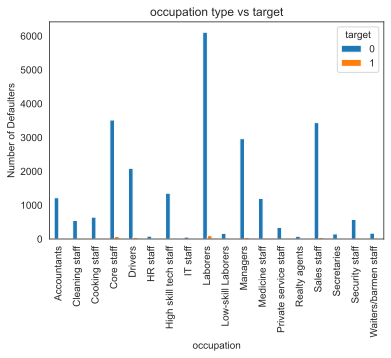

In [41]:
pd.crosstab(new_data.occyp,new_data.target).plot(kind='bar') #Computed a simple cross tabulation of two factors- a frequency table of the factors 
plt.title('occupation type vs target')
plt.xlabel('occupation')
plt.ylabel('Number of Defaulters')

Text(0, 0.5, 'Number of Defaulters')

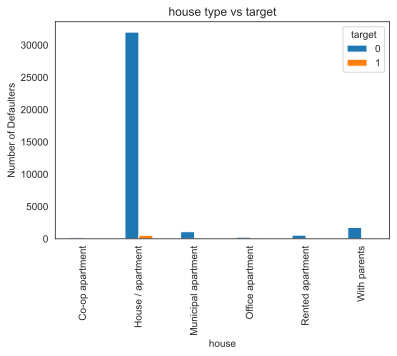

In [42]:
pd.crosstab(new_data.houtp,new_data.target).plot(kind='bar')
plt.title('house type vs target')
plt.xlabel('house')
plt.ylabel('Number of Defaulters')

Text(0.5, 1.0, 'education type vs target')

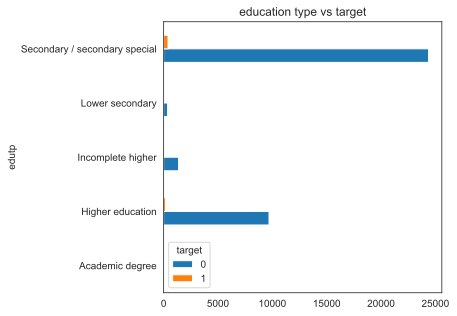

In [43]:
pd.crosstab(new_data.edutp, new_data.target).plot(kind='barh', figsize=(5,5))
plt.title('education type vs target')

Text(0.5, 1.0, 'family type vs target')

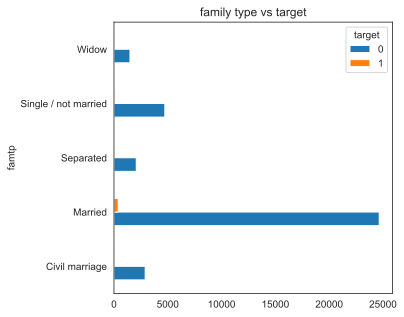

In [44]:
pd.crosstab(new_data.famtp, new_data.target).plot(kind='barh', figsize=(5,5))
plt.title('family type vs target')

In [45]:
px.box(data_frame=new_data, x='occyp', y='Age') #interactive boxplot with plotly.express module was used to identify dependecies

In [46]:
px.box(data_frame=new_data, x='occyp', y='inc') #as an illustration, outliers are detected in laborers, Security Staff and were target for elimination

### lmplot is intended as a convenient interface to fit regression models across conditional subsets of a dataset. We assign variables to different facets by using hue for this most important comparison.

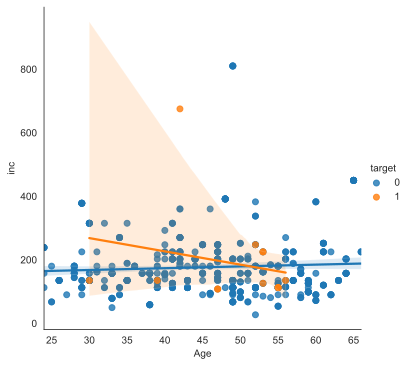

In [47]:
sns.lmplot(data=new_data[new_data['occyp']=='Security staff'], x='Age', y='inc', hue='target')
#Plotting data and regression model fits across a FacetGrid.
#the salary of Security staff is increasing with age

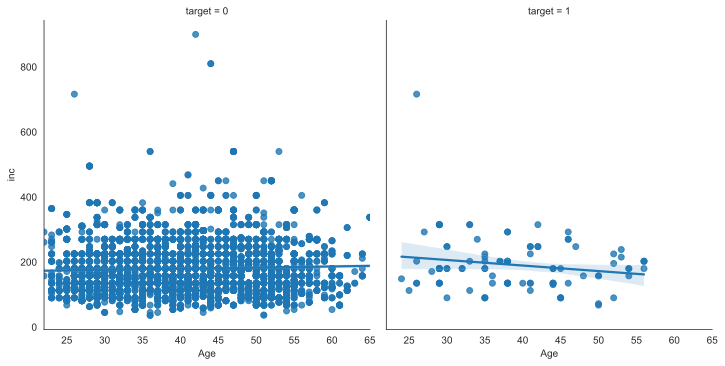

In [48]:
sns.lmplot(data=new_data[new_data['occyp']=='Laborers'], x='Age', y='inc',col='target',palette="Set1")
#the salary of Laborers is increasing with age

#### the way of handling outliers using queries

In [49]:
new_data.drop(new_data.query('occyp=="Laborers" and Age > 45 and inc > 200').index, inplace=True)
#data.drop(data.query('OCCUPATION_TYPE=="Laborers" and AGE > 55').index, inplace=True)
new_data.drop(new_data.query('occyp=="Laborers" and inc > 400').index, inplace=True)

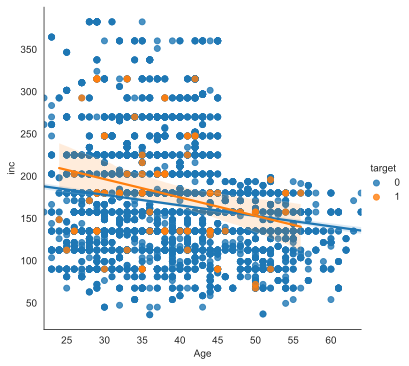

In [50]:
sns.lmplot(data=new_data[new_data['occyp']=='Laborers'], x='Age', y='inc', hue='target')

In [51]:
new_data.drop(new_data.query('occyp=="Security staff" and Age > 50 and inc > 200').index, inplace=True)

new_data.drop(new_data.query('occyp=="Security staff" and inc > 400').index, inplace=True)

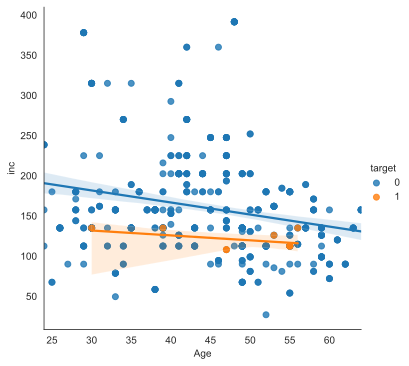

In [52]:
sns.lmplot(data=new_data[new_data['occyp']=='Security staff'], x='Age', y='inc', hue='target')

In [53]:
new_data.drop(new_data.query('occyp=="Laborers" and Age > 55').index, inplace=True)

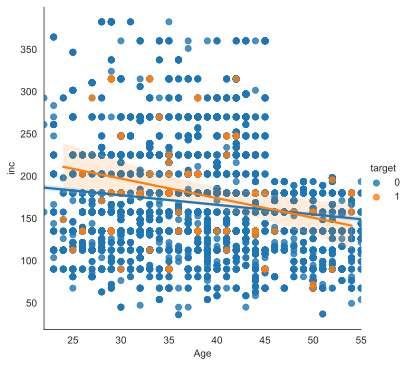

In [54]:
sns.lmplot(data=new_data[new_data['occyp']=='Laborers'], x='Age', y='inc', hue='target')

In [55]:
new_data.T

0                 1      \
ID                       5008804           5008805   
Gender                         M                 M   
Car                            Y                 Y   
Reality                        Y                 Y   
ChldNo                         0                 0   
inc                        427.5             427.5   
inctp                    Working           Working   
edutp           Higher education  Higher education   
famtp             Civil marriage    Civil marriage   
houtp           Rented apartment  Rented apartment   
DAYS_BIRTH                -12005            -12005   
DAYS_EMPLOYED              -4542             -4542   
FLAG_MOBIL                     1                 1   
wkphone                        1                 1   
phone                          0                 0   
email                          0                 0   
occyp                        NaN               NaN   
famsize                        2                 2   
MONTHS_BALANCE               -15               -14   
dep_value                      0                 0   
target                         0                 0   
Age                           33                33   

                                        2                              3      \
ID                                    5008806                        5008808   
Gender                                      M                              F   
Car                                         Y                              N   
Reality                                     Y                              Y   
ChldNo                                      0                              0   
inc                                     112.5                            270   
inctp                                 Working           Commercial associate   
edutp           Secondary / secondary special  Secondary / secondary special   
famtp                                 Married           Single / not married   
houtp                       House / apartment              House / apartment   
DAYS_BIRTH                             -21474                         -19110   
DAYS_EMPLOYED                           -1134                          -3051   
FLAG_MOBIL                                  1                              1   
wkphone                                     0                              0   
phone                                       0                              1   
email                                       0                              1   
occyp                          Security staff                    Sales staff   
famsize                                     2                              1   
MONTHS_BALANCE                            -29                             -4   
dep_value                                   0                              0   
target                                      0                              0   
Age                                        59                             52   

                                        4                              5      \
ID                                    5008809                        5008810   
Gender                                      F                              F   
Car                                         N                              N   
Reality                                     Y                              Y   
ChldNo                                      0                              0   
inc                                       270                            270   
inctp                    Commercial associate           Commercial associate   
edutp           Secondary / secondary special  Secondary / secondary special   
famtp                    Single / not married           Single / not married   
houtp                       House / apartment              House / apartment   
DAYS_BIRTH                             -19110                  

In [56]:
new_data = new_data.mask(new_data == 'NULL').dropna() 
#replacing missing values by NaN and dropping rows contatining them, reduced total number of rows from 36457 to 25134

In [57]:
ivtable = pd.DataFrame(new_data.columns, columns=['variable']) 
#creating a new dataframe called with one column ‘variables’ and rows given by the names of columns in the ‘new_data’ dataframe
ivtable.shape

(22, 1)

In [58]:
ivtable['IV']= None 
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)
#remove the rows associated with the following variables: ‘mobile’, ‘begin_month’, ‘dep_value’, ‘target’, ‘ID’, 
#since they are not informative for our analysis

In [59]:
ivtable.shape

(18, 2)

In [60]:
ivtable.head()

variable    IV
1   Gender  None
2      Car  None
3  Reality  None
4   ChldNo  None
5      inc  None

## Auxiliar functions

## Weight of Evidence and Information Value
<p>The weight of evidence (WoE) tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan. and "Good Customers" refers to the customers who paid back loan. WoE serves as a basis to calculate Information Value.</p>
<p>Information value is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance.</p>
</p>According to Siddiqi (2006), by convention the values of the IV statistic in credit scoring can be interpreted as follows.
If the IV statistic is:</p>
<ul>
<li>Less than 0.02, then the predictor is not useful for modeling</li>
<li>0.02 to 0.1, then the predictor has only a weak relationship to the Goods/Bads odds ratio</li>
<li>0.1 to 0.3, then the predictor has a medium strength relationship to the Goods/Bads odds ratio</li>
<li>0.3 to 0.5, then the predictor has a strong relationship to the Goods/Bads odds ratio</li>
<li>> 0.5, suspicious relationship</li>
</ul>

In [61]:
#defining the function which will allow us to calculate the information value for each variable
def calc_iv(df, feature, target, pr = False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

#collecting information about the values of the variable:
    for i in range(df[feature].nunique()):                                          
        val = list(df[feature].unique())[i]                                         # For each unique value the variable takes:
        lst.append([feature,                                                        # Variable name
                    val,                                                            # Value 
                    df[df[feature] == val].count()[feature],                        # The total number of times this value used
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Number of 'good' times (default == 0) 
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Number of 'bad' times (default == 1)

#combining the collected information in one table:
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum() # % of the unique value in the total number of values
    data['Bad Rate'] = data['Bad'] / data['All'] # % of the 'bad' cases
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum()) # % of 'good' cases for the unique value
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum() # % of 'bad' cases for the unique value
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad']) # calculating WoE
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})  # replacing infinite values (if any) with 0

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad']) # calculating IV

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True]) # sorting the data
    data.index = range(len(data.index)) # creating an index

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum() # final IV for the variable is calculated as a sum of IVs for each unique value of this variable
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

## Dummy variable
<p>A dummy variable is a numeric variable that represents categorical data.</p>
<p>Technically, dummy variables are dichotomous, quantitative variables. They can take on only two quantitative values: '1' or '0'. Typically, 1 represents the presence of a qualitative attribute, and 0 represents its absence.</p>
<p>While creating a dummy we need to choose the baseline: one of the qualitative attributes that will be removed from the dummy table and used uniquely as a reference for others. </p>

In [62]:
# defining a function which creates a dummy variable for a specific variable used in the model:
def convert_dummy(df, feature, rank = 0):
    # creating a new dataframe where rows are the same as in original database 
    # columns are represented by the unique values of the variable 
    # and associating '1' for rows (clients) that correspond to this value and '0' otherwise:
    pos = pd.get_dummies(df[feature], prefix = feature) 
    # finding the value which is used the biggest number of times:
    mode = df[feature].value_counts().index[rank] 
    biggest = feature + '_' + str(mode)
    # dropping this value from the dataframe:
    pos.drop([biggest], axis = 1, inplace=True)
    # dropping the column associated with the variable in the original dataframe
    df.drop([feature],axis=1,inplace=True) 
    # merging the dummy dataframe to the original one
    df=df.join(pos)
    return df

<p>Since we are working with different types of variables we need to adapt them to the function defined for analysis. 
Here we will define a function that bins variable's values into buckets based on two methods:</p>
<ul>
<li>quantile cut which creates equal size bins (same number of values in each bin)</li>
<li>edge cut which creates equal-value-range bins (number of values in bins may vary)</li>
</ul>
<p>This function is used to go from a continuous variable to a categorical variable. For example, it will convert ages to groups of age ranges. </p>

In [63]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # edge cut
    # creating a new dataframe with columns given by labels used for bins:
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    # adding the new column to the original dataset
    df[name] = localdf[col].astype(object)
    return df

## Confusion Matrix (Plot)
<p>For our future prediction analysis we will use methods requiring the construction of confusion matrix in order to display the results. Also known as an error matrix, confusion matrix is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one.</p>
<p>The name stems from the fact that it makes it easy to see if the system is confusing two classes. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class. In particular, having two possible actual outcomes 'Positive' and 'Negative' and two predictive factors 'True' and 'False', the quadrants 'True - Negative' and 'True - Positive' will indicate the actual outcomes correctly predicted by the model and specify the accuracy level of the predictive model for each outcome. The average accuracy level of the model will be given by the mean between this two indicators. </p>

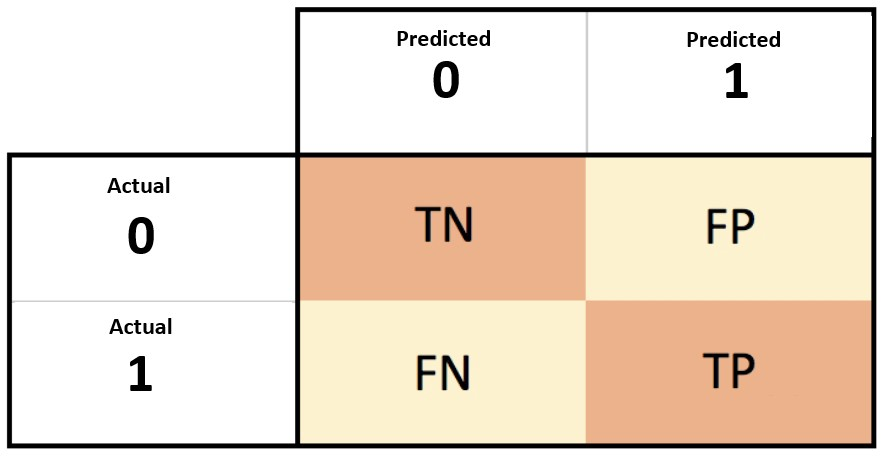

In [64]:
from IPython.display import Image
Image(filename='DecisionTree.jpeg') 

In [65]:
import itertools # we will use this library tools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues): # choosing blue theme for the graph
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # calculating the outlining indicators 
        
    print(cm) # printing the confusion matrix
    # designing the graph:
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # will be displaying data as 2D image
    plt.title(title) # adding title
    plt.colorbar() # adding colorbar
    # setting tick marks:
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # editing the indicators representation on the graph:
    fmt = '.2f' if normalize else 'd' # setting the data type
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),                              # formatting the text
                 horizontalalignment="center",                             # setting central allignment
                 color="white" if cm[i, j] > thresh else "black")          # setting color of the text

    plt.tight_layout() # adjusting plot parameters for a better fit in to the figure area
    # setting the axes labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Binary Variables

### Gender

In [66]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1]) # manually creating a dummy
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data, 'Gender', 'target') # calculating IV
ivtable.loc[ivtable['variable']=='Gender','IV'] = iv # adding the IV value to the 'ivtable'
data.head()

0    15268
1     8847
Name: Gender, dtype: int64
This variable's IV is: 0.03021471679838292
0    15268
1     8847
Name: Gender, dtype: int64


Variable  Value    All   Good  Bad     Share  Bad Rate  Distribution Good  \
0   Gender      0  15268  15045  223  0.633133  0.014606           0.634569   
1   Gender      1   8847   8664  183  0.366867  0.020685           0.365431   

   Distribution Bad       WoE        IV  
0          0.549261  0.144372  0.012316  
1          0.450739 -0.209811  0.017899

### Car

In [67]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1]) # manually creating a dummy
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target') # calculating IV
ivtable.loc[ivtable['variable']=='Car','IV']=iv # adding this value to 'ivtable'
data.head()

0    14071
1    10044
Name: Car, dtype: int64
This variable's IV is: 0.0006174807582718395
0    14071
1    10044
Name: Car, dtype: int64


Variable  Value    All   Good  Bad     Share  Bad Rate  Distribution Good  \
0      Car      0  14071  13839  232  0.583496  0.016488           0.583702   
1      Car      1  10044   9870  174  0.416504  0.017324           0.416298   

   Distribution Bad       WoE        IV  
0          0.571429  0.021252  0.000261  
1          0.428571 -0.029057  0.000357

In [68]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1]) # manually creating the dummy
print(new_data['Reality'].value_counts()) 
iv, data=calc_iv(new_data,'Reality','target') # calculating IV
ivtable.loc[ivtable['variable']=='Reality','IV']=iv # adding this value to 'ivtable'
data.head()

1    15791
0     8324
Name: Reality, dtype: int64
This variable's IV is: 0.02700924133858449
1    15791
0     8324
Name: Reality, dtype: int64


Variable  Value    All   Good  Bad     Share  Bad Rate  Distribution Good  \
0  Reality      0   8324   8152  172  0.345179  0.020663           0.343836   
1  Reality      1  15791  15557  234  0.654821  0.014819           0.656164   

   Distribution Bad       WoE        IV  
0          0.423645 -0.208733  0.016659  
1          0.576355  0.129688  0.010350

### Phone

In [69]:
new_data['phone']=new_data['phone'].astype(str) # changing type to str 
print(new_data['phone'].value_counts(normalize=True,sort=False)) 
iv, data=calc_iv(new_data,'phone','target') # calculating IV
ivtable.loc[ivtable['variable']=='phone','IV']=iv # adding this value to 'ivtable'
data.head()

0    0.706656
1    0.293344
Name: phone, dtype: float64
This variable's IV is: 0.0014195194721152173
0    17041
1     7074
Name: phone, dtype: int64


Variable Value    All   Good  Bad     Share  Bad Rate  Distribution Good  \
0    phone     0  17041  16761  280  0.706656  0.016431           0.706947   
1    phone     1   7074   6948  126  0.293344  0.017812           0.293053   

   Distribution Bad       WoE        IV  
0          0.689655  0.024764  0.000428  
1          0.310345 -0.057330  0.000991

### Email

In [70]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str) # changing type to str
iv, data=calc_iv(new_data,'email','target') # calculating IV
ivtable.loc[ivtable['variable']=='email','IV']=iv # adding this value to 'ivtable'
data.head()

0    0.898196
1    0.101804
Name: email, dtype: float64
This variable's IV is: 3.0381100011434534e-05
0    21660
1     2455
Name: email, dtype: int64


Variable Value    All   Good  Bad     Share  Bad Rate  Distribution Good  \
0    email     0  21660  21296  364  0.898196  0.016805           0.898224   
1    email     1   2455   2413   42  0.101804  0.017108           0.101776   

   Distribution Bad       WoE        IV  
0          0.896552  0.001864  0.000003  
1          0.103448 -0.016300  0.000027

### Work phone

In [71]:
new_data['wkphone']=new_data['wkphone'].astype(str) # changing type to str
iv, data = calc_iv(new_data,'wkphone','target') # calculating IV
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv # adding this value to 'ivtable'
data.head()

This variable's IV is: 0.0034975359339272033
0    17445
1     6670
Name: wkphone, dtype: int64


Variable Value    All   Good  Bad     Share  Bad Rate  Distribution Good  \
0  wkphone     0  17445  17162  283  0.723409  0.016222            0.72386   
1  wkphone     1   6670   6547  123  0.276591  0.018441            0.27614   

   Distribution Bad       WoE        IV  
0          0.697044  0.037749  0.001012  
1          0.302956 -0.092679  0.002485

## Continuous Variables

### Number of children

In [72]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More' # replacing the values which are equal or greater than 2 by ‘2More’
print(new_data['ChldNo'].value_counts(sort=False))

0        15060
1         6007
2More     3048
Name: ChldNo, dtype: int64


In [73]:
iv, data=calc_iv(new_data,'ChldNo','target') # calculating IV
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv # adding this value to 'ivtable'
data.head()

This variable's IV is: 0.0013953316113945486
0        15060
1         6007
2More     3048
Name: ChldNo, dtype: int64


Variable  Value    All   Good  Bad     Share  Bad Rate  Distribution Good  \
0   ChldNo      0  15060  14800  260  0.624508  0.017264           0.624236   
1   ChldNo      1   6007   5912   95  0.249098  0.015815           0.249357   
2   ChldNo  2More   3048   2997   51  0.126394  0.016732           0.126408   

   Distribution Bad       WoE        IV  
0          0.640394 -0.025556  0.000413  
1          0.233990  0.063606  0.000977  
2          0.125616  0.006285  0.000005

In [74]:
#we turn our data of number of children into a dummy variable. Our category of reference will be 0 children
new_data = convert_dummy(new_data,'ChldNo')  

In [75]:
# check our new dummy variable
new_data.head()

ID  Gender  Car  Reality    inc                 inctp  \
2  5008806       1    1        1  112.5               Working   
3  5008808       0    0        1  270.0  Commercial associate   
4  5008809       0    0        1  270.0  Commercial associate   
5  5008810       0    0        1  270.0  Commercial associate   
6  5008811       0    0        1  270.0  Commercial associate   

                           edutp                 famtp              houtp  \
2  Secondary / secondary special               Married  House / apartment   
3  Secondary / secondary special  Single / not married  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   
5  Secondary / secondary special  Single / not married  House / apartment   
6  Secondary / secondary special  Single / not married  House / apartment   

   DAYS_BIRTH  ...  phone  email           occyp famsize MONTHS_BALANCE  \
2      -21474  ...      0      0  Security staff     2.0          -29.0   
3      -19110  ...      1      1     Sales staff     1.0           -4.0   
4      -19110  ...      1      1     Sales staff     1.0          -26.0   
5      -19110  ...      1      1     Sales staff     1.0          -26.0   
6      -19110  ...      1      1     Sales staff     1.0          -38.0   

  dep_value  target  Age  ChldNo_1  ChldNo_2More  
2         0       0   59         0             0  
3         0       0   52         0             0  
4         0       0   52         0             0  
5         0       0   52         0             0  
6         0       0   52         0             0  

[5 rows x 23 columns]

### Annual Income

In [76]:
new_data['inc'] = new_data['inc'] / 10000 # change of units 

In [77]:
# See the distribution of this variable
print(new_data['inc'].value_counts(bins = 10, sort = False)) 
#new_data['inc'].plot(kind = 'hist', bins = 70, density = True)  #10 bins was good to see few income ranges, but wasn't useful visually

(0.0015500000000000002, 0.0182]    14468
(0.0182, 0.0337]                    7773
(0.0337, 0.0491]                    1532
(0.0491, 0.0646]                     157
(0.0646, 0.0801]                     121
(0.0801, 0.0956]                      43
(0.0956, 0.111]                        4
(0.111, 0.127]                         3
(0.127, 0.142]                         6
(0.142, 0.158]                         8
Name: inc, dtype: int64


In [78]:
# Discretization of the variable into equal-sized buckets based on sample quantiles. We'll use three categories low, medium and high.
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
# Calculate the information value of annual income
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

This variable's IV is: 0.0047238623587834185
low       8883
high      7896
medium    7336
Name: gp_inc, dtype: int64


Variable   Value   All  Good  Bad     Share  Bad Rate  Distribution Good  \
0   gp_inc    high  7896  7751  145  0.327431  0.018364           0.326922   
1   gp_inc     low  8883  8736  147  0.368360  0.016548           0.368468   
2   gp_inc  medium  7336  7222  114  0.304209  0.015540           0.304610   

   Distribution Bad       WoE        IV  
0          0.357143 -0.088413  0.002672  
1          0.362069  0.017518  0.000112  
2          0.280788  0.081432  0.001940

In [79]:
new_data = convert_dummy(new_data,'gp_inc') # convert our new categorized income into a categorical variable. Low will be the reference category

### Age

In [80]:
new_data['Age'] =- (new_data['DAYS_BIRTH'])//365 # calculate the age of the clients in years 
# see the distribution of out variable 
print(new_data['Age'].value_counts(bins = 5,normalize=True,sort=False))
#new_data['Age'].plot(kind='hist',bins=20,density=True)

(19.951999999999998, 29.4]    0.165706
(29.4, 38.8]                  0.323616
(38.8, 48.2]                  0.316442
(48.2, 57.6]                  0.160854
(57.6, 67.0]                  0.033382
Name: Age, dtype: float64


In [81]:
# Discretization of the variable into equal-sized buckets. We'll use five categories described below.
new_data = get_category(new_data, 'Age' , 5, ["lowest","low","medium","high","highest"])
# Calculate the information value for this variable
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable'] == 'DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.0514496208563297
low        7804
medium     7631
lowest     3996
high       3879
highest     805
Name: gp_Age, dtype: int64


Variable    Value   All  Good  Bad     Share  Bad Rate  Distribution Good  \
0   gp_Age     high  3879  3798   81  0.160854  0.020882           0.160192   
1   gp_Age  highest   805   801    4  0.033382  0.004969           0.033785   
2   gp_Age      low  7804  7684  120  0.323616  0.015377           0.324096   
3   gp_Age   lowest  3996  3913   83  0.165706  0.020771           0.165043   
4   gp_Age   medium  7631  7513  118  0.316442  0.015463           0.316884   

   Distribution Bad       WoE        IV  
0          0.199507 -0.219476  0.008629  
1          0.009852  1.232310  0.029492  
2          0.295567  0.092147  0.002629  
3          0.204433 -0.214038  0.008431  
4          0.290640  0.086449  0.002269

In [82]:
# Convert our new discretized age variable into a categorical variable. Our reference category will be Age 39-48 "medium"
new_data = convert_dummy(new_data,'gp_Age') 

### Days employed (Years employed)

<AxesSubplot:ylabel='Frequency'>

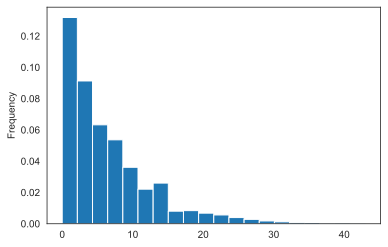

In [83]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365 # Calculate how many years has this client been employed
new_data[new_data['worktm']<0] = np.nan # drop the values of the ones that are unemployed
#new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) # fill nan values will the mean
new_data['worktm'].plot(kind='hist',bins=20,density=True) # see the distribution of the data

In [84]:
# Discretization of the variable into equal-sized buckets. We'll use five categories described below.
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
# Calculate the information value for this variable
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
#data.head()

This variable's IV is: 0.037642746653429975
lowest     17629
low         4781
medium      1282
high         343
highest       80
Name: gp_worktm, dtype: int64


In [85]:
# Convert our new discretized seniority variable into a categorical variable. Our reference category will be "lowest"
new_data = convert_dummy(new_data,'gp_worktm')

### Family size

In [86]:
new_data['famsize'].value_counts(sort=False) #count number of observations per number of family members

2.0     11997
1.0      4104
3.0      5116
4.0      2518
6.0        51
9.0         2
5.0       305
7.0        18
20.0        1
15.0        3
Name: famsize, dtype: int64

In [87]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize'] # create a new grouped family size variable
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more' # assign "3more" to every family that has more than 3 members
iv, data=calc_iv(new_data,'famsizegp','target') #calculate the information value of the variable 
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

This variable's IV is: 0.005208435005248862
2        11997
3more     8014
1         4104
Name: famsizegp, dtype: int64


Variable  Value    All   Good  Bad     Share  Bad Rate  Distribution Good  \
0  famsizegp      1   4104   4024   80  0.170185  0.019493           0.169725   
1  famsizegp      2  11997  11799  198  0.497491  0.016504           0.497659   
2  famsizegp  3more   8014   7886  128  0.332324  0.015972           0.332616   

   Distribution Bad       WoE        IV  
0          0.197044 -0.149252  0.004078  
1          0.487685  0.020246  0.000202  
2          0.315271  0.053557  0.000929

In [88]:
new_data = convert_dummy(new_data,'famsizegp') # turn our variable into a categorical variable. Reference variable: 2 members 

## Categorical Features
This variables are already categorical so we just need to see if all the categories are relevant, if we can pool them in a new category and to generate the respective dummy variables. 
### Income Type

In [89]:
# observe the distribution of the variable
print(new_data['inctp'].value_counts(sort = False))
print('--------------------')
print(new_data['inctp'].value_counts(normalize=True,sort=False))
print('--------------------')
#assign "state servant" to every pensioner or student
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
#calculate the information value for this variable
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv

data.head()

State servant            2397
Commercial associate     6798
Student                    10
Working                 14898
Pensioner                  12
Name: inctp, dtype: int64
--------------------
State servant           0.099399
Commercial associate    0.281899
Student                 0.000415
Working                 0.617790
Pensioner               0.000498
Name: inctp, dtype: float64
--------------------
This variable's IV is: 9.324307657908314e-05
Working                 14898
Commercial associate     6798
State servant            2419
Name: inctp, dtype: int64


Variable                 Value    All   Good  Bad     Share  Bad Rate  \
0    inctp  Commercial associate   6798   6682  116  0.281899  0.017064   
1    inctp         State servant   2419   2379   40  0.100311  0.016536   
2    inctp               Working  14898  14648  250  0.617790  0.016781   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.281834          0.285714 -0.013674  0.000053  
1           0.100342          0.098522  0.018299  0.000033  
2           0.617824          0.615764  0.003341  0.000007

In [90]:
new_data = convert_dummy(new_data,'inctp') # create the respective dummy variable. Reference variable : 'Working'

### Occupation Type

In [91]:
#organize our variable into only three categories: labor worker, office worker and high tech worker. 
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts()) # see the new dsitribution of our variable

#calculate the information value
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

officewk     10183
Laborwk       9477
hightecwk     4455
Name: occyp, dtype: int64
This variable's IV is: 0.0054416969182998695
officewk     10183
Laborwk       9477
hightecwk     4455
Name: occyp, dtype: int64


Variable      Value    All   Good  Bad     Share  Bad Rate  \
0    occyp    Laborwk   9477   9308  169  0.392992  0.017833   
1    occyp  hightecwk   4455   4375   80  0.184740  0.017957   
2    occyp   officewk  10183  10026  157  0.422268  0.015418   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.392594          0.416256 -0.058526  0.001385  
1           0.184529          0.197044 -0.065622  0.000821  
2           0.422877          0.386700  0.089434  0.003236

In [92]:
new_data = convert_dummy(new_data,'occyp') #Converting categorical variable into dummy/indicator variables

### House type

This categorical variable contains different house types which were divided into 5 sub-categoriesfor which  Information value, the total number of customers with bad and good debt indicators, and corresponding distributions for each sub-category were calculated.

In [93]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

This variable's IV is: 0.005652097645975668
House / apartment      21161
With parents            1415
Municipal apartment      782
Rented apartment         421
Office apartment         191
Co-op apartment          145
Name: houtp, dtype: int64


Variable                Value    All   Good  Bad     Share  Bad Rate  \
0    houtp      Co-op apartment    145    142    3  0.006013  0.020690   
1    houtp    House / apartment  21161  20808  353  0.877504  0.016682   
2    houtp  Municipal apartment    782    766   16  0.032428  0.020460   
3    houtp     Office apartment    191    186    5  0.007920  0.026178   
4    houtp     Rented apartment    421    416    5  0.017458  0.011876   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.005989          0.007389 -0.210042  0.000294  
1           0.877641          0.869458  0.009368  0.000077  
2           0.032308          0.039409 -0.198663  0.001411  
3           0.007845          0.012315 -0.450948  0.002016  
4           0.017546          0.012315  0.353991  0.001852

In [94]:
new_data = convert_dummy(new_data,'houtp') # #Converting categorical variable into dummy/indicator variables

### Education

This categorical variable contains different education types which were divided into 4 sub-categories for which  Information value, the total number of customers with bad and good debt indicators, and corresponding distributions for each sub-category were calculated.

In [95]:
#pandas .loc is used to access a group of rows by labels
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

This variable's IV is: 0.01444112049135595
Secondary / secondary special    16018
Higher education                  6945
Incomplete higher                  978
Lower secondary                    174
Name: edutp, dtype: int64


Variable                          Value    All   Good  Bad     Share  \
0    edutp               Higher education   6945   6817  128  0.287995   
1    edutp              Incomplete higher    978    957   21  0.040556   
2    edutp                Lower secondary    174    168    6  0.007215   
3    edutp  Secondary / secondary special  16018  15767  251  0.664234   

   Bad Rate  Distribution Good  Distribution Bad       WoE        IV  
0  0.018431           0.287528          0.315271 -0.092112  0.002555  
1  0.021472           0.040364          0.051724 -0.247976  0.002817  
2  0.034483           0.007086          0.014778 -0.735052  0.005654  
3  0.015670           0.665022          0.618227  0.072965  0.003414

In [96]:
new_data = convert_dummy(new_data,'edutp') # #Converting categorical variable into dummy/indicator variables

### Family type 

This categorical variable contains different education types which were divided into 5 sub-categories for which  Information value, the total number of customers with bad and good debt indicators, and corresponding distributions for each sub-category were calculated.

In [97]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Single / not married    0.139208
Separated               0.058097
Civil marriage          0.083475
Married                 0.695874
Widow                   0.023346
Name: famtp, dtype: float64

In [98]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

This variable's IV is: 0.03456962960528844
Married                 16781
Single / not married     3357
Civil marriage           2013
Separated                1401
Widow                     563
Name: famtp, dtype: int64


Variable                 Value    All   Good  Bad     Share  Bad Rate  \
0    famtp        Civil marriage   2013   1982   31  0.083475  0.015400   
1    famtp               Married  16781  16513  268  0.695874  0.015970   
2    famtp             Separated   1401   1386   15  0.058097  0.010707   
3    famtp  Single / not married   3357   3278   79  0.139208  0.023533   
4    famtp                 Widow    563    550   13  0.023346  0.023091   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.083597          0.076355  0.090618  0.000656  
1           0.696487          0.660099  0.053659  0.001953  
2           0.058459          0.036946  0.458870  0.009872  
3           0.138260          0.194581 -0.341716  0.019246  
4           0.023198          0.032020 -0.322288  0.002843

In [99]:
new_data = convert_dummy(new_data,'famtp') # #Converting categorical variable into dummy/indicator variables

### Information value summary

In [100]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
#pandas .loc is used to access a group of columns by labels which were appended to ivtable
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'  
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable #for each feature, returns the value which gives information on the variable's ability to predict

variable           IV
10           agegp    0.0514496
11        worktmgp    0.0376427
8            famtp    0.0345696
1           Gender    0.0302147
3          Reality    0.0270092
7            edutp    0.0144411
9            houtp    0.0056521
16           occyp    0.0054417
17         famsize   0.00520844
5            incgp   0.00472386
13         wkphone   0.00349754
14           phone   0.00141952
4           ChldNo   0.00139533
2              Car  0.000617481
6            inctp  9.32431e-05
15           email  3.03811e-05
18  MONTHS_BALANCE         None
21             Age         None

Relationship between IV value and predictive power

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Almost no predictive power | 
|0.02~0.1 |weak predictive power|
|0.1~0.3|Moderate predictive power|
|0.3~0.5|Strong predictive power|
|>0.5|Predictive power is too strong, need to check variables| 

In [101]:
a=ivtable.loc[ivtable['IV']<=0.02]
VarofWeakPredictivePower=ivtable.loc[(ivtable['IV']>0.02) & (ivtable['IV']<=0.1)]
c=ivtable.loc[(ivtable['IV']>0.1) & (ivtable['IV']<=0.3)] #empty
d=ivtable.loc[(ivtable['IV']>0.3) & (ivtable['IV']<=0.5)] #empty
e=ivtable.loc[ivtable['IV']>0.5]   #empty

In [102]:
VarofWeakPredictivePower

variable         IV
10     agegp  0.0514496
11  worktmgp  0.0376427
8      famtp  0.0345696
1     Gender  0.0302147
3    Reality  0.0270092

In [103]:
#new_data.to_csv (r'C:\Users\Asus\1Python\export_dataframe.csv', index = False, header=True)

## Algorithms

In [104]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'MONTHS_BALANCE',
       'dep_value', 'target', 'Age', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_lowest',
       'gp_Age_medium', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_Laborwk',
       'occyp_hightecwk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

In [105]:
new_data.columns.shape

(47,)

In [106]:
# gp_Age low changed for medium, officewk replaced by laborwk
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_medium',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_Laborwk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow']]

In [107]:
X.shape

(24115, 29)

Using Synthetic Minority Over-Sampling Technique(SMOTE) to overcome sample imbalance problem. 

In [108]:
#conda install -c conda-forge imbalanced-learn

In [109]:
Y = Y.astype('int')
from imblearn.over_sampling import SMOTE
X_balance,Y_balance = SMOTE().fit_sample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

In [110]:
#?SMOTE.fit_sample

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

### Logistic Regression

The logistic regression is the primary algorithm used for classification. It assigns observations to two or more classes. In this work, the classes are two: "well-behaved client" and "badly-behaved client". 

The term logistic comes from the fact that the output (predicted variable) is transformed via a logistic function (sigmoid function particularly). This transformation reduces the range of the output variable to the interval [0,1]. By assigning the value of one to the client that defaults ("badly-behaved"), we will be able to treat the output as the probability of the client defaulting on her debt. 

In order to classify the output into the discrete class, a decision boundary is set to 0.5; this is a threshold above which the algorithm will assign class "bad" (1) or class "good" (0). 

Given the non-linear nature of the logistic regression, a particular cost function is required. We will use the Cross-entropy cost function, which increases as the predicted probability diverges from the actual label. And finally, the optimization algorithm used in our implementation is the gradient-descent method.

Accuracy Score is 0.6527484886826936
      0     1
0  4066  3047
1  1893  5220
[[0.57162941 0.42837059]
 [0.26613243 0.73386757]]


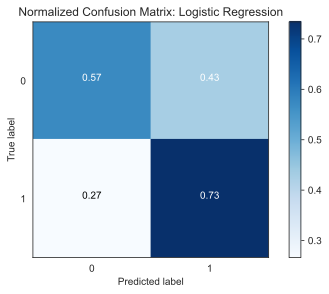

In [112]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state=0, solver='lbfgs')
clf = logit.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Accuracy Score is',accuracy_score(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style("white") 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

### Decision Tree

<p>Decision tree learning is one of the predictive modelling approaches used in statistics, data mining and machine learning. It uses a decision tree as a predictive model to go from observations about an item represented in the branches to conclusions about the item's target value represented in the leaves. So the basic goal of a decision tree is to split a population of data into smaller segments. There are two stages to prediction. The first stage is training the model—this is where the tree is built, tested, and optimized by using an existing collection of data. In the second stage, you actually use the model to predict an unknown outcome.</p> 
<p>We will not plot the Decision Tree itself, since we have a very large data. However, we will use the model results and will interpret them via the Confusion Matrix.

Accuracy Score is 0.8995501194995079
      0     1
0  6162   951
1   478  6635
[[0.86630114 0.13369886]
 [0.0672009  0.9327991 ]]


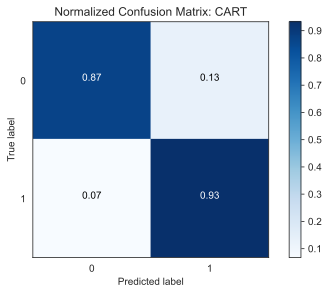

In [113]:
from sklearn.tree import DecisionTreeClassifier # importing the classifier
dt = DecisionTreeClassifier()
dtfit = dt.fit(X_train, y_train) #fitting the data
y_predict = dtfit.predict(X_test) # predicting values of y
print('Accuracy Score is',accuracy_score(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: CART')

As seen on the graph above the Decision Tree model is 95% accurate predicting defaults and 85% accurate predicting the absence of defaults in given framework. The average accuracy level of this model is 90%.

### Random Forest 

Random forest is a supervised learning algorithm. This means it works with labeled data and learns by example. The algorithm needs a training data set consisting of inputs paired with the correct outputs. After training, the algorithm will be capable of labeling new information based on the relations identified in the training set. In our case, we face a classification problem, we need to classify loan applicants as good or bad costumers.

A Random forest is a collection of decision trees, also called ensemble. Each decision tree is generated on randomly selected subsets of the data and using an attribute selection indicator such as information gain, gini index or others. When using gini the algorithm calculates how much the model fit or accuracy decreases when it drops a variable. The larger the decrease, the more significant the predictive power of that variable. 

By boostraping the subsamples and the attributes, each tree gives a different classification and the most popular class between all of them is chosen as the final result. This method helps overcome the overfitting issue in decision trees. Random forest are considered highly accurate and robust because of the several decision trees involved. It could be seen as if each tree prevents the others from its own biases. It can be used either for classification or regression. And, it helps selecting the most relevant features. On the other hand, it is slower than decision trees and it can be more difficult to interpret. 

Accuracy Score is 0.9010965837199494
      0     1
0  6173   940
1   467  6646
[[0.8678476  0.1321524 ]
 [0.06565444 0.93434556]]


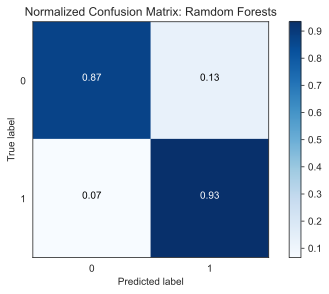

In [114]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rffit = rf.fit(X_train, y_train)
y_predict = rffit.predict(X_test)
print('Accuracy Score is',accuracy_score(y_test, y_predict))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')